In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pyodbc
import sklearn
import os


In [2]:
# Change this path to run in your machine
home_path = 'C:/Users/54911/OneDrive/Documentos/git_repos/elecciones2023-arg'

In [3]:
os.chdir(home_path)

In [4]:
political_posts = pd.read_csv('Elecciones + IA/modeling/Preparando_datos/political_posts.csv')


In [5]:
primera_vuelta = pd.read_csv('Elecciones + IA/getting_data/surveys/data_scraped/normalize_primera_vuelta.csv')
ballotage = pd.read_csv('Elecciones + IA/getting_data/surveys/data_scraped/normalize_ballotage.csv')
primera_vuelta_poly = pd.read_csv('Elecciones + IA/modeling/polynomial_surveys/polynomial_primera_vuelta.csv')
ballotaje_poly = pd.read_csv('Elecciones + IA/modeling/polynomial_surveys/polynomial_ballotage.csv')


In [6]:
def stringToDatetime(fecha):
    #format_string = '%Y-%m-%d'
    anio,mes,dia= fecha.split('-')
    aux_dia = dia.split(' ')
    if len(aux_dia)>1:dia = aux_dia[0]
    res = datetime(int(anio),int(mes),int(dia))
    return res


In [7]:
political_posts['fecha'] = pd.to_datetime(political_posts['fecha'])
primera_vuelta['Final'] = pd.to_datetime(primera_vuelta['Final'])
primera_vuelta['Inicio'] = pd.to_datetime(primera_vuelta['Inicio'])

In [8]:
indx_row = 1
inicio = primera_vuelta_poly.iloc[indx_row]['Inicio']
final = primera_vuelta_poly.iloc[indx_row]['Final']

In [9]:
prueba = political_posts[(political_posts['fecha']>inicio)& (political_posts['fecha']<final)]

In [10]:
prueba['partido'].value_counts()

Union por la Patria     35
Juntos por el Cambio    34
La Libertad Avanza       3
Name: partido, dtype: int64

In [42]:
sum_percen = np.zeros(len(primera_vuelta_poly))
for i in range(len(primera_vuelta_poly)):
    sum_percen[i] = sum(primera_vuelta_poly.iloc[50,:5].to_numpy())

In [43]:
sum_percen = np.array(sum_percen)

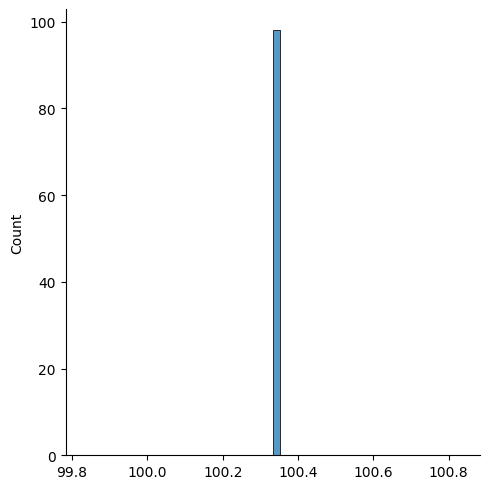

In [45]:
sns.displot(sum_percen,bins=50)

In [7]:
def seleccionar_publicaciones_fecha(encuesta, publicacion):
    res = []
    for i in range(len(encuesta)):
        encuesta_row = encuesta.iloc[i]
        inicio_fecha = encuesta_row['Inicio']
        final_fecha = encuesta_row['Final']

        publicaciones_periodo = publicacion[(publicacion['fecha']>=inicio_fecha) & (publicacion['fecha']<=final_fecha)]
        res.append(publicaciones_periodo)
    
    return res

In [8]:
def para_entrenar(tabla_una_fecha,k,partidos,canales,datos_encuestas):
    
    encuesta_porcentajes = datos_encuestas[partidos].iloc[k]
    df = pd.DataFrame(columns=partidos)
    df_encuestas = pd.DataFrame(columns=partidos)
    fuentes_lista = canales
    
    agrupado_likes = tabla_una_fecha.groupby(['Partido','fuente'])['cantidad_likes'].median()
    fecha_median = tabla_una_fecha['fecha'].median()

    for p in list(partidos):

        if p in agrupado_likes.index:
            likes_partidos = agrupado_likes[p]
            fuentes_partido = likes_partidos.index
            likes_median = []

            for c in canales:
                if c in fuentes_partido:
                    likes_median.append(likes_partidos[c])
                else:
                    likes_median.append(0)
        
            df[p] = likes_median
        else:
            df[p] = [0]*len(canales)

        df_encuestas[p] = [encuesta_porcentajes[p]]*len(df)

    df_encuestas.rename(columns=lambda x: x+'_Encuestas',inplace=True)
    df['Fuente'] = fuentes_lista
    df['fecha_mediana'] = fecha_median

    res = pd.concat([df,df_encuestas],axis=1)

    return res

In [9]:
def juntar_tablas_preparadas(tabla_periodos,partidos,canales,datos_encuestas):
    #partidos = encuestas.columns[:5]
    tablas_entrenar = []
    for k,t in enumerate(tabla_periodos):
        tablas_entrenar.append(para_entrenar(t,k,partidos,canales,datos_encuestas))

    data = pd.concat(tablas_entrenar)
    return data

In [10]:
def separar_fecha(data):
    data['dia'] = ''
    data['mes'] = ''
    data['anio'] = ''
    data['dia'] = data['fecha_mediana'].map(lambda x:x.day)
    data['mes'] = data['fecha_mediana'].map(lambda x:x.month)
    data['anio'] = data['fecha_mediana'].map(lambda x:x.year)
    

In [11]:
def encoding_Fuente(tabla,fuentes):
    #fuentes_labels = publicaciones['fuente'].unique()
    numbers = [i+1 for i in range(len(fuentes))]
    simple_encoding = dict(zip(fuentes,numbers))
    tabla['Fuente'] = tabla['Fuente'].map(lambda x:simple_encoding[x])

In [12]:
def listo_para_entrenar(datos_publicaciones,datos_encuestas):
    fuentes = datos_publicaciones['fuente'].unique()
    partidos = datos_encuestas.columns.tolist()[:-2]

    datos_publicaciones['fecha'] = datos_publicaciones['fecha'].map(lambda x:pasar_a_datetime(x))
    datos_encuestas['Inicio'] = datos_encuestas['Inicio'].map(lambda x:pasar_a_datetime(x))
    datos_encuestas['Final'] = datos_encuestas['Final'].map(lambda x:pasar_a_datetime(x))

    #datos_publicaciones['cantidad_likes'].quantile(0.95)
    datos_publicaciones = datos_publicaciones[datos_publicaciones['cantidad_likes']<25000]

    tabla_periodos = seleccionar_publicaciones_fecha(datos_encuestas,datos_publicaciones)

    data = juntar_tablas_preparadas(tabla_periodos,partidos,fuentes,datos_encuestas)
    
    separar_fecha(data)
    encoding_Fuente(data,fuentes)
    return data

In [14]:
primera_vuelta_poly['Inicio'] = primera_vuelta_poly['Inicio'].map(lambda x : pasar_a_datetime(x))
primera_vuelta_poly = primera_vuelta_poly[primera_vuelta_poly['Inicio'].map(lambda x: x.year)==2023]
primera_vuelta_poly['Inicio'] = primera_vuelta_poly['Inicio'].map(lambda x : str(x))

In [15]:
data_primera_vuelta = listo_para_entrenar(publicaciones,primera_vuelta).dropna()
data_solo_ballotaje = listo_para_entrenar(publicaciones,solo_ballotaje).dropna()

In [16]:
data_encuestas_poly = listo_para_entrenar(publicaciones,primera_vuelta_poly).dropna()
data_ballotaje_poly = listo_para_entrenar(publicaciones,ballotaje_poly).dropna()

In [17]:
data_encuestas_poly.drop('anio',axis=1,inplace=True)
data_ballotaje_poly.drop('anio',axis=1,inplace=True)

In [21]:
data_primera_vuelta.to_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/Preparando_datos/data_primera_vuelta.csv',index=False)
#data_median.to_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/data_median.csv',index=False)
data_solo_ballotaje.to_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/Preparando_datos/data_solo_ballotaje.csv',index=False)

In [22]:
data_ballotaje_poly.to_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/Preparando_datos/data_ballotaje_poly.csv',index=False)
data_encuestas_poly.to_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/Preparando_datos/data_encuestas_poly.csv',index=False)